In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import random
import time
import itertools
import math
from graphviz import Digraph

In [2]:
almNum = 3
ocorr = 10
t_sample = 60
base_hour = dt.datetime(2018, 1,9,9,0,0)
occor_num = 0

#Settings alarms
a = np.zeros(1, dtype=int)
duration = 120 #120sec
hour_init = base_hour

b = np.zeros(1, dtype=int)
pAb = 1
delay_b = 120#seconds
duration_b =120

c = np.zeros(1, dtype=int)
pAc = 1
delay_c = 120#seconds
duration_c = 120

#Alarm Series Generation, A (cause), B(Effect). C(Effect)
while(occor_num < ocorr): 
    #A generation - begin
    srtd_hour = random.normalvariate(3, 1)
    srtd_hour_begin = hour_init + dt.timedelta(hours=srtd_hour)
    srtd_hour_end = srtd_hour_begin + dt.timedelta(seconds = duration)

    idx_init_a_occor = int(math.ceil((srtd_hour_begin - base_hour).total_seconds()/t_sample))
    idx_end_a_occor = int(math.ceil((srtd_hour_end - base_hour).total_seconds()/t_sample))
        
    if(idx_end_a_occor > a.size):
            a.resize(idx_end_a_occor)

    for i in np.arange(idx_init_a_occor, idx_end_a_occor + 1):
        a[i-1] = 1
    #A generation - end
         
    
    #B generation begin
    srtd_prob_b = random.uniform(0,1)  
    if srtd_prob_b <= pAb:
        srtd_hour_begin_b = srtd_hour_begin + dt.timedelta(seconds = delay_b)
        srtd_hour_end_b = srtd_hour_begin_b + dt.timedelta(seconds=duration_b)

        idx_init_b_occor = int(math.ceil((srtd_hour_begin_b - base_hour).total_seconds()/t_sample))
        idx_end_b_occor = int(math.ceil((srtd_hour_end_b - base_hour).total_seconds()/t_sample))

        if(idx_end_b_occor > b.size):
                b.resize(idx_end_b_occor)

        for j in np.arange(idx_init_b_occor, idx_end_b_occor +1):
            b[j-1] =  1  
    #B generation end

    #C generation begin
    srtd_prob_c = random.uniform(0,1)
    if srtd_prob_c <= pAc:
        srtd_hour_begin_c = srtd_hour_begin + dt.timedelta(seconds = delay_c)
        srtd_hour_end_c = srtd_hour_begin_c + dt.timedelta(seconds=duration_c)

        idx_init_c_occor = int(math.ceil((srtd_hour_begin_c - base_hour).total_seconds()/t_sample))
        idx_end_c_occor = int(math.ceil((srtd_hour_end_c - base_hour).total_seconds()/t_sample))
        
        if(idx_end_c_occor > c.size):
            c.resize(idx_end_c_occor)

        for j in np.arange(idx_init_c_occor, idx_end_c_occor +1):
            c[j-1] = 1    
    #C generation end
    
    hour_init = srtd_hour_begin
    occor_num = occor_num + 1

#Making series the same length
max_len = max(a, b, c, key=len).size
a = np.concatenate([a, np.zeros(max_len - a.size)])
b = np.concatenate([b, np.zeros(max_len - b.size)])
c = np.concatenate([c, np.zeros(max_len - c.size)])
sum(c)

30.0

In [28]:
def graph(df, limite, eng = 'dot'):
    g = Digraph(engine=eng)
    for k, row in enumerate(df.index):
        if any(df.iloc[k]>=limite) or any(df[row] >= limite):
            g.node(str(k),row, shape='oval', fontsize='10', width='0') 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df[col]):
            if row  >=limite:
                g.edge(str(i), str(j), label=str(np.round(row,3)),\
                       color="#000000{:02x}".format(int(255)))
                
                       #* row//max(df.max()))
    return g    

In [5]:
def plot_mat_corrs(figsize, annot, matrix):
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
    sns.heatmap(matrix, cmap=cmap, center=0, annot=annot)
    plt.yticks(rotation=45)
    plt.xticks(rotation=45)
    plt.show()

In [6]:
#guess window_lag = ceil(delay_b_c/t_sample)

def interrelation(window_lag, matrix):
    #window_lag =  5#shoud be minor than size of the series

    print(matrix.shape)
    count_occor = 0;
    corr_mat = np.zeros([matrix.shape[1],matrix.shape[1]], dtype=float)
    alrms = {}
    for i in np.arange(0, matrix.shape[1]):
        alrms[i] = matrix[:,i]
    #print(alrms)
    for idx_caus, value in alrms.items():
        reduced_alarms = alrms.copy()
        del reduced_alarms[idx_caus]
        for idx_occor_caus, occor in enumerate(value):
            if occor == 1:
                if(idx_occor_caus+window_lag < len(value)):
                    count_occor = count_occor + 1
                    for idx_fct, alm_redu in reduced_alarms.items():
                        counted = False
                        for idx_occor_fct in np.arange(idx_occor_caus+1, idx_occor_caus+1+window_lag):
                            if alm_redu[idx_occor_fct] == 1 and  not counted:
                                counted = True
                                corr_mat[idx_caus][idx_fct] = corr_mat[idx_caus][idx_fct]+1
        if count_occor > 0: 
            corr_mat[idx_caus] = corr_mat[idx_caus]/count_occor
            count_occor = 0
    return corr_mat

In [5]:
#plot_mat_corrs(figsize=(30,20), annot=True, matrix=corr)

In [5]:

dist6 = pd.read_csv('dist6.csv', names=['xmeas%02d_low' % x for x in range(1, 74)] + ['xmeas%02d_high' % x for x in range(1, 74)])
dist6_sel_vars = dist6[ ['xmeas01_low', 'xmeas02_low', 'xmeas03_low', 
        'xmeas08_low', 'xmeas09_low', 'xmeas21_low',
        'xmeas01_high', 'xmeas02_high', 'xmeas03_high',
        'xmeas08_high', 'xmeas09_high', 'xmeas21_high']].copy()


(51201, 12)


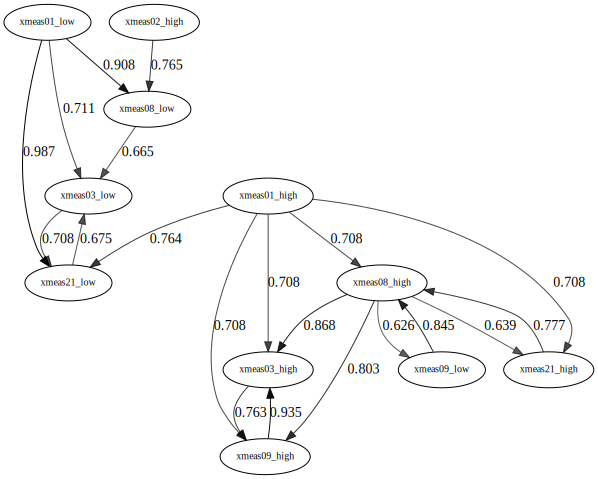

In [93]:
#Corr wity raw data
dist6_first_diff = dist6_sel_vars.diff(1)
dist6_first_diff.iloc[0] = dist6_sel_vars.iloc[0]

corr = interrelation(100, dist6_first_diff.as_matrix())

df_cors = pd.DataFrame(corr, columns= dist6_sel_vars.columns,      
        index= dist6_sel_vars.columns)
df_cors

graph(df_cors, 0.6, 'dot')

(51182, 12)


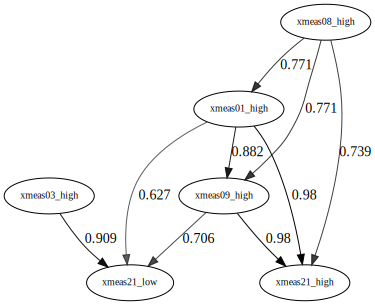

In [98]:
#Moving mean application

window = 20 #window of moving mean
dist_roll  = dist6_sel_vars.rolling(window).mean() 
dist_roll.dropna(inplace=True)
dist_roll = dist_roll.round(decimals=0,).copy()
dist_roll.reset_index(drop=True, inplace=True)

dist6_first_diff = dist_roll.diff(1)
dist6_first_diff.iloc[0] = dist_roll.iloc[0]

corr_move = interrelation(100, dist6_first_diff.as_matrix())

df_cors = pd.DataFrame(corr_move, columns= dist6_sel_vars.columns,      
        index= dist6_sel_vars.columns)
df_cors


graph(df_cors, 0.6, 'dot')

(51201, 6)


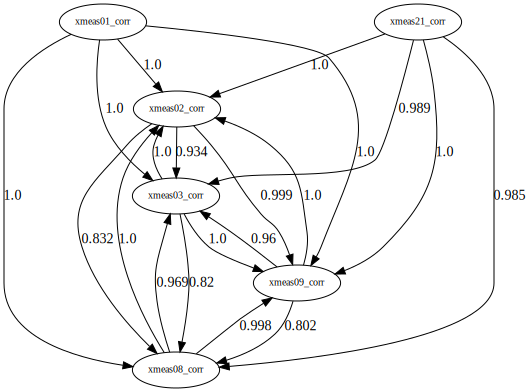

In [29]:
#Thresold method: Correlation

dist6_corr = pd.read_csv('dist6_data/alm_seq_corr_dist6.csv')
dist6_corr.drop("tout", axis = 1)
dist6_corr_svars = dist6_corr[['xmeas01_corr', 'xmeas02_corr', 'xmeas03_corr',\
                               'xmeas08_corr', 'xmeas09_corr', 'xmeas21_corr']].copy()

window = 5
dist_roll  = dist6_corr_svars.rolling(window).mean() 
dist_roll.dropna(inplace=True)
dist_roll = dist_roll.round(decimals=0,).copy()
dist_roll.reset_index(drop=True, inplace=True)

dist6_corr_svars_diff = dist_roll.diff(1)
dist6_corr_svars_diff.iloc[0] = dist_roll.iloc[0]
dist6_corr_svars_diff = dist6_corr_svars.clip(0,1).copy()

corr = interrelation(100, dist6_corr_diff.as_matrix())

df_cors_corr = pd.DataFrame(corr, columns= dist6_corr_diff.columns,      
        index= dist6_corr_diff.columns)

graph(df_cors_corr, 0.6, 'dot')

